# Sample Notebook for Zero-Shot Inference with CheXzero
This notebook walks through how to use CheXzero to perform zero-shot inference on a chest x-ray image dataset.

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Optional

import sys
sys.path.append('../')

from eval import evaluate, bootstrap
from zero_shot import make, make_true_labels, run_softmax_eval

%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/mnt/nas_houbb/users/Benjamin/PyCharm_Deployment/CheXzero/notebooks


## Directories and Constants

In [3]:
## Define Zero Shot Labels and Templates

# ----- DIRECTORIES ------ #
cxr_filepath: str = '../data/chexpert_test.h5' # filepath of chest x-ray images (.h5)
cxr_true_labels_path: Optional[str] = '../data/test_frontal.csv' # (optional for evaluation) if labels are provided, provide path
model_dir: str = '../checkpoints/pt-imp' # where pretrained models are saved (.pt) 
predictions_dir: Path = Path('../predictions') # where to save predictions
cache_dir: str = predictions_dir / "cached" # where to cache ensembled predictions

context_length: int = 77

# ------- LABELS ------  #
# Define labels to query each image | will return a prediction for each label
cxr_labels: List[str] = ['Atelectasis','Cardiomegaly', 
                                      'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
                                      'Lung Opacity', 'No Finding','Pleural Effusion', 'Pleural Other', 'Pneumonia', 
                                      'Pneumothorax', 'Support Devices']

# ---- TEMPLATES ----- # 
# Define set of templates | see Figure 1 for more details                        
cxr_pair_template: Tuple[str] = ("{}", "no {}")

# ----- MODEL PATHS ------ #
# If using ensemble, collect all model paths
model_paths = []
for subdir, dirs, files in os.walk(model_dir):
    for file in files:
        full_dir = os.path.join(subdir, file)
        model_paths.append(full_dir)

        
model_paths = [model_paths[-1]]

print(model_paths)

['../checkpoints/pt-imp/checkpoint_60000.pt']


## Run Inference

In [4]:
## Run the model on the data set using ensembled models
def ensemble_models(
    model_paths: List[str], 
    cxr_filepath: str, 
    cxr_labels: List[str], 
    cxr_pair_template: Tuple[str], 
    cache_dir: str = None, 
    save_name: str = None,
) -> Tuple[List[np.ndarray], np.ndarray]: 
    """
    Given a list of `model_paths`, ensemble model and return
    predictions. Caches predictions at `cache_dir` if location provided.

    Returns a list of each model's predictions and the averaged
    set of predictions.
    """

    predictions = []
    model_paths = sorted(model_paths) # ensure consistency of 
    for path in model_paths: # for each model
        model_name = Path(path).stem

        # load in model and `torch.DataLoader`
        model, loader = make(
            model_path=path, 
            cxr_filepath=cxr_filepath, 
        ) 
        
        # path to the cached prediction
        if cache_dir is not None:
            if save_name is not None: 
                cache_path = Path(cache_dir) / f"{save_name}_{model_name}.npy"
            else: 
                cache_path = Path(cache_dir) / f"{model_name}.npy"

        # if prediction already cached, don't recompute prediction
        if cache_dir is not None and os.path.exists(cache_path): 
            print("Loading cached prediction for {}".format(model_name))
            y_pred = np.load(cache_path)
        else: # cached prediction not found, compute preds
            print("Inferring model {}".format(path))
            y_pred = run_softmax_eval(model, loader, cxr_labels, cxr_pair_template)
            if cache_dir is not None: 
                Path(cache_dir).mkdir(exist_ok=True, parents=True)
                np.save(file=cache_path, arr=y_pred)
        predictions.append(y_pred)
    
    # compute average predictions
    y_pred_avg = np.mean(predictions, axis=0)
    
    return predictions, y_pred_avg

In [5]:
predictions, y_pred_avg = ensemble_models(
    model_paths=model_paths, 
    cxr_filepath=cxr_filepath, 
    cxr_labels=cxr_labels, 
    cxr_pair_template=cxr_pair_template, 
    cache_dir=cache_dir,
)

/mnt/nas_houbb/users/Benjamin/_venv/python39/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Inferring model ../checkpoints/pt-imp/checkpoint_60000.pt


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

In [6]:
# save averaged preds
pred_name = "chexpert_preds.npy" # add name of preds
predictions_dir = predictions_dir / pred_name
np.save(file=predictions_dir, arr=y_pred_avg)

In [7]:
predictions_dir

PosixPath('../predictions/chexpert_preds.npy')

## (Optional) Evaluate Results
If ground truth labels are available, compute AUC on each pathology to evaluate the performance of the zero-shot model. 

In [9]:
# make test_true
test_pred = y_pred_avg
test_true = make_true_labels(cxr_true_labels_path=cxr_true_labels_path, cxr_labels=cxr_labels)

# evaluate model
cxr_results = evaluate(test_pred, test_true, cxr_labels)

# boostrap evaluations for 95% confidence intervals
bootstrap_results = bootstrap(test_pred, test_true, cxr_labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
# display AUC with confidence intervals
bootstrap_results[1]

,Atelectasis_auc,Cardiomegaly_auc,Consolidation_auc,Edema_auc,Enlarged Cardiomediastinum_auc,Fracture_auc,Lung Lesion_auc,Lung Opacity_auc,No Finding_auc,Pleural Effusion_auc,Pleural Other_auc,Pneumonia_auc,Pneumothorax_auc,Support Devices_auc
mean,0.7354,0.8764,0.8712,0.8534,0.8919,0.5269,0.7316,0.8832,0.2210,0.8946,0.5400,0.7281,0.5791,0.7556
lower,0.6926,0.8437,0.8036,0.8087,0.8625,0.1754,0.6181,0.8542,0.1695,0.8648,0.3702,0.5360,0.3949,0.7117
upper,0.7755,0.9048,0.9283,0.8912,0.9184,0.8745,0.8440,0.9102,0.2761,0.9231,0.6828,0.8815,0.7715,0.7960


In [11]:
# for i in test_pred:
#     print(i)

cxr_results

,Atelectasis_auc,Cardiomegaly_auc,Consolidation_auc,Edema_auc,Enlarged Cardiomediastinum_auc,Fracture_auc,Lung Lesion_auc,Lung Opacity_auc,No Finding_auc,Pleural Effusion_auc,Pleural Other_auc,Pneumonia_auc,Pneumothorax_auc,Support Devices_auc
0,0.735276,0.875607,0.8718,0.854099,0.891982,0.535673,0.734774,0.882966,0.220523,0.894362,0.536479,0.731576,0.581096,0.755013


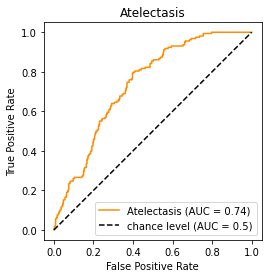

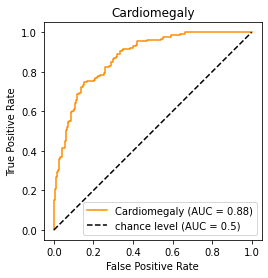

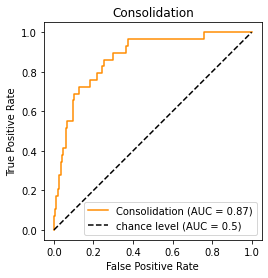

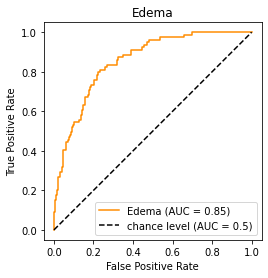

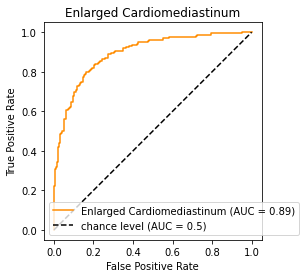

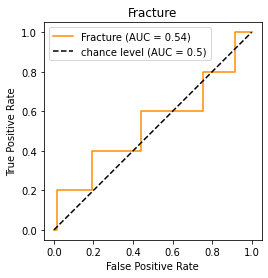

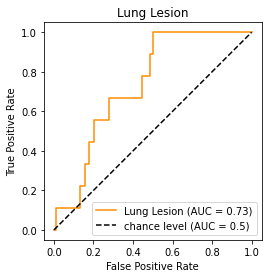

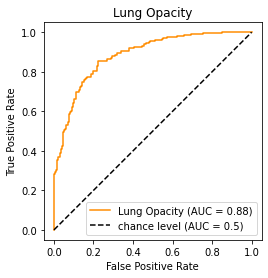

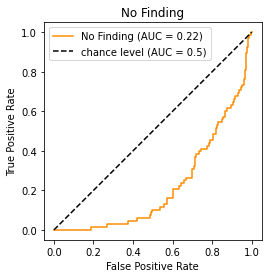

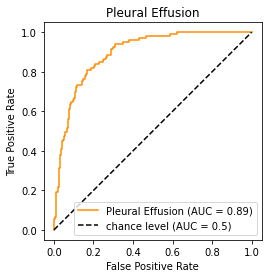

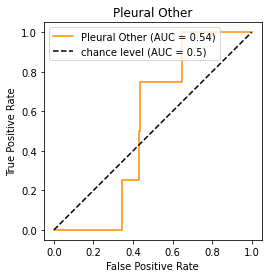

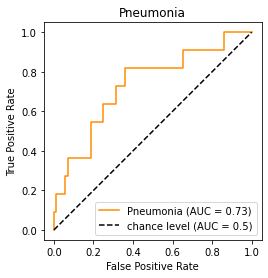

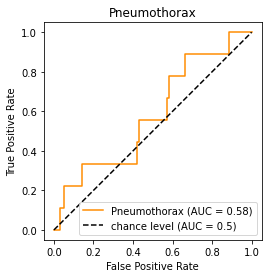

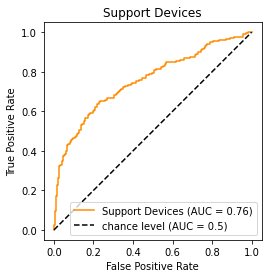

In [12]:

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


for i in range(14):
    RocCurveDisplay.from_predictions(
        test_true[:, i], test_pred[:, i],
        name=f"{cxr_labels[i]}",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{cxr_labels[i]}")
    plt.legend()
